# Régression logistique

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
import json
import time

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

from tools import (COLUMNS_CAT, COLUMNS_QUANT, Modelisation, SearchCV,
                   best_score_CV, datasets, graph_2scores_CV,
                   graph_2scores_CV_comp, graph_3scores_CV, graph_param_CV,
                   restauration_CV, PDF)

## Matplotlib : 
# Pour affichage interactif (notamment 3D) dans notebook
# %matplotlib widget

# Pour affichage interactif (notamment 3D) dans une fenêtre qt externe au notebook
# %matplotlib qt

# Pour affichage simple dans notebook
# %config InlineBackend.figure_format = 'png'

pdf = PDF('output/model_LR/')

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df, drop='first')
X_quant = datasets_df['X_quant_scaled']
X_cat = datasets_df['X_cat']
X = datasets_df['X_only_quant_scaled']
y = datasets_df['y']

Columns_quant : default
Columns_cat : default
drop : first

Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

## 1. Modèle brut
### 1.1. Variables quantitatives

Export PDF : output/model_LR/00.pdf



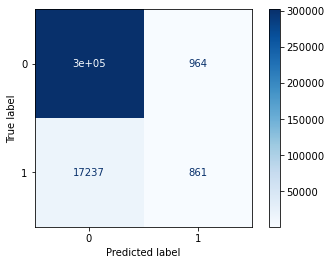

f1 : 0.0864
f3 : 0.0523
f5 : 0.0493
recall : 0.0476
negative predictive value : 0.9459
precision : 0.4718
roc_auc : 0.7416
training time : 1.905s
prediction time : 0.011s


In [4]:
m = Modelisation(X_quant, y, LogisticRegression())
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

Export PDF : output/model_LR/01.pdf



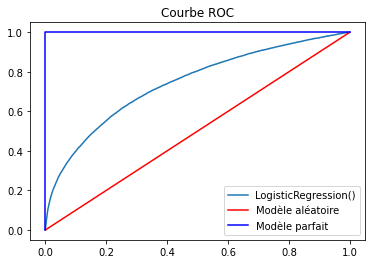

In [5]:
m.show_ROC(pdf=pdf)

In [6]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.024253
campaignctrlast24h,0.360169
dayssincelastvisitdouble,-0.030111
ltf_nbglobaldisplay_4w,0.009265
ltf_nbpartnerdisplayssincelastclick,-0.021091
ltf_nbpartnerdisplay_90d,-0.015635
ltf_nbpartnerclick_90d,0.035097
ltf_nbpartnersales_90d,-0.009538
nbdayssincelastclick,-0.109477
nbdisplay_1hour,-0.220216


In [7]:
X_ = add_constant(X_quant)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197291
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1603554
Model:                          Logit   Df Residuals:                  1603540
Method:                           MLE   Df Model:                           13
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:                 0.09816
Time:                        01:09:22   Log-Likelihood:            -3.1637e+05
converged:                       True   LL-Null:                   -3.5080e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.0392      0.0

### 1.2. Variables catégorielles

In [8]:
# Nombre de valeurs distinctes
for column in COLUMNS_CAT:
    print(f"{column} : {df[column].nunique()}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 5
is_interstitial : 2
device_type : 7
hour : 24
weekday : 7


Export PDF : output/model_LR/02.pdf



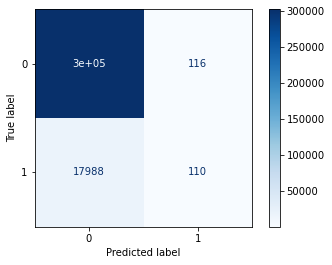

f1 : 0.0120
f3 : 0.0067
f5 : 0.0063
recall : 0.0061
negative predictive value : 0.9439
precision : 0.4867
roc_auc : 0.6911
training time : 14.664s
prediction time : 0.028s


In [9]:
m = Modelisation(X_cat, y, LogisticRegression())
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

### 1.3. Variables quantitatives + catégorielles

Export PDF : output/model_LR/03.pdf



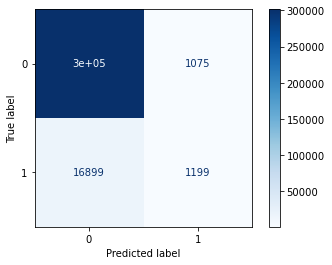

f1 : 0.1177
f3 : 0.0726
f5 : 0.0686
recall : 0.0663
negative predictive value : 0.9469
precision : 0.5273
roc_auc : 0.7592
training time : 10.92s
prediction time : 0.028s


In [10]:
m = Modelisation(X, y, LogisticRegression())
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

Export PDF : output/model_LR/04.pdf



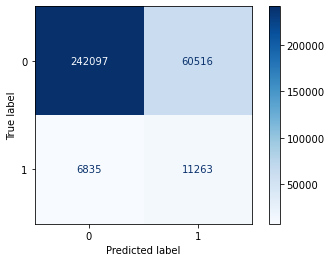

f1 : 0.2506
f3 : 0.4800
f5 : 0.5586
recall : 0.6223
negative predictive value : 0.9725
precision : 0.1569
roc_auc : 0.7808
training time : 8.136s
prediction time : 0.03s


In [11]:
m = Modelisation(X, y, LogisticRegression(class_weight='balanced'))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

## 2. Tuning des hyperparamètres avec GridSearchCV

In [12]:
model = LogisticRegression()

cv_params = {
    "C": np.logspace(-6, 2, 30),
    "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8},
                     {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18},
                     {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28},
                     {0:1, 1:30}, {0:1, 1:32}]
}

print(len(ParameterGrid(cv_params)))

540


In [13]:
# SearchCV(model, cv_params, data_frac=1, drop='first', scaling=True, sparse=True, n_jobs=35)

In [14]:
dico, results = restauration_CV('LR_CV_Grid_540_1')

model : LogisticRegression()
model_name : LR
type : GridSearchCV
len_grid : 540
columns_quant : default
columns_cat : default
drop : first
data_frac : 1
n_jobs : 35
temps : 40min, 23.764s
params : {'C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0: 1, 1: 8}, {0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 14}, {0: 1, 1: 16}, {0: 1, 1: 18}, {0: 1, 1: 20}, {0: 1, 1: 22}, {0: 1, 1: 24}, {0: 1, 1: 26}, {0: 1, 1: 28}, {0: 1, 1: 30}, {0:

Export PDF : output/model_LR/05.pdf



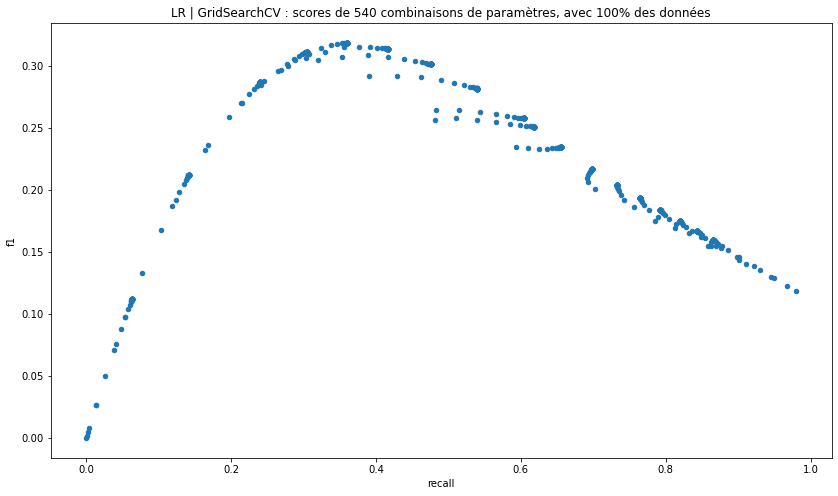

In [15]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20, pdf=pdf)

Export PDF : output/model_LR/06.pdf



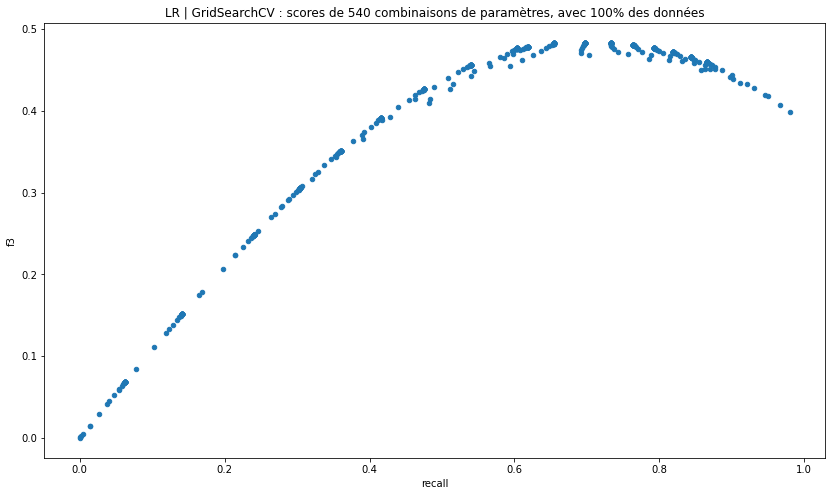

In [16]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=20, pdf=pdf)

Export PDF : output/model_LR/07.pdf



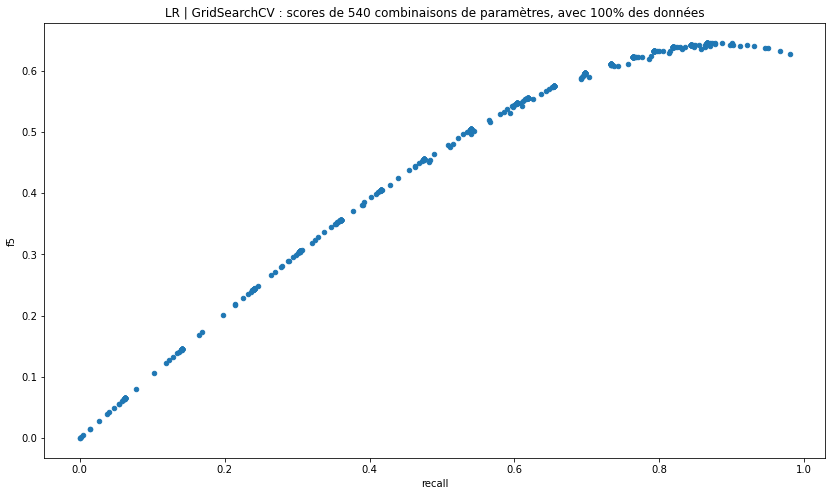

In [17]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=20, pdf=pdf)

Export PDF : output/model_LR/08.pdf



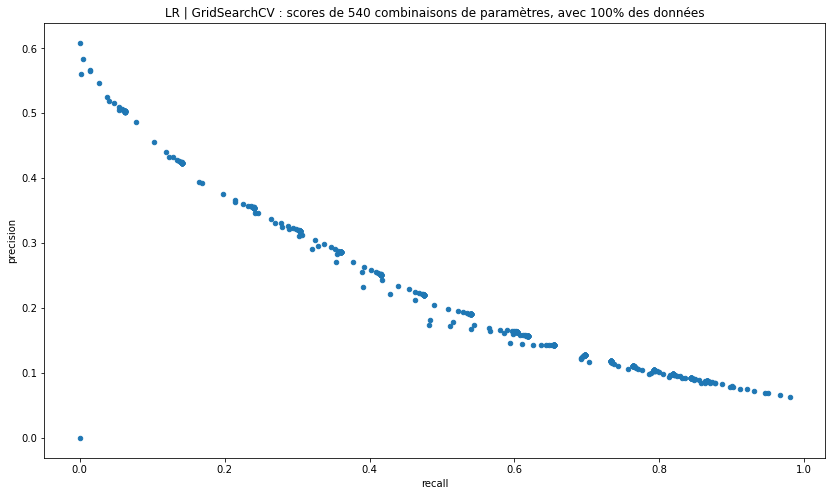

In [18]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=20, pdf=pdf)

Export PDF : output/model_LR/09.pdf



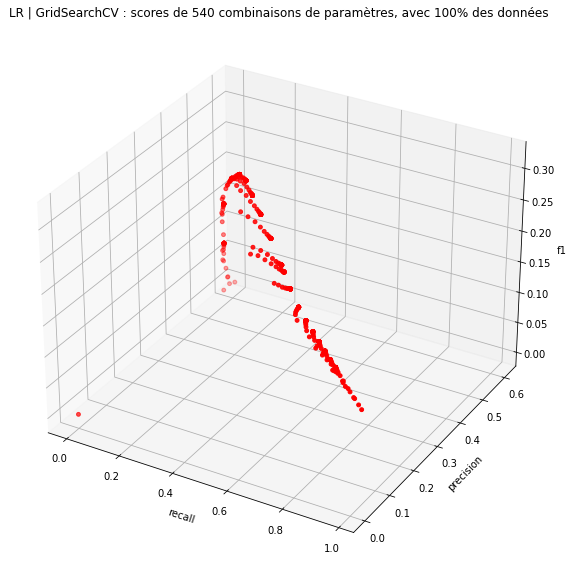

In [19]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=15, pdf=pdf)

Export PDF : output/model_LR/10.pdf



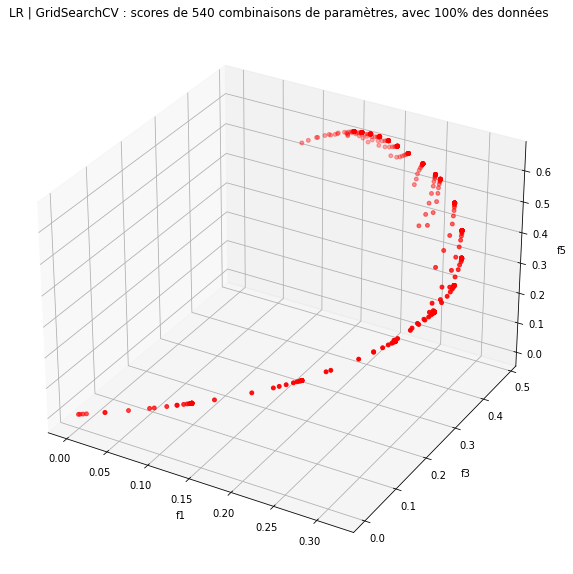

In [20]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=15, pdf=pdf)

Export PDF : output/model_LR/11.pdf



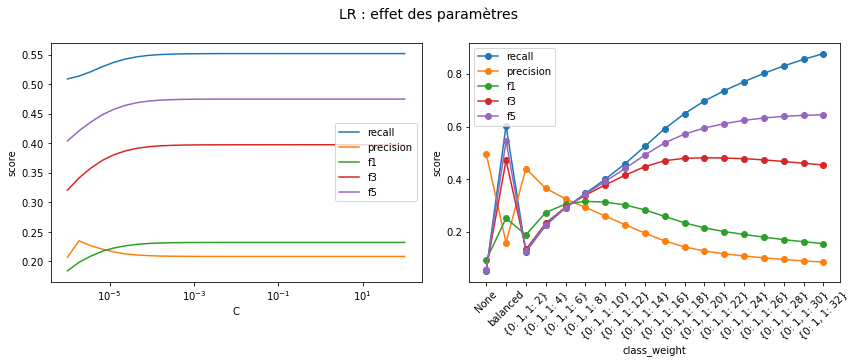

In [21]:
graph_param_CV(dico, results, xscale={'C': 'log'}, ncols=2, height=5, width=6, pdf=pdf)

In [22]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,mean_test_recall,std_test_recall,rank_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
353,36.953844,7.506459,1.786794,0.634562,0.174333,"{0: 1, 1: 20}","{'C': 0.17433288221999874, 'class_weight': {0:...",0.697654,0.00333,182,...,330,0.216664,0.000875,269,0.48314,0.00193,1,0.595893,0.002581,181
461,35.24751,8.307536,1.840514,0.702285,7.880463,"{0: 1, 1: 20}","{'C': 7.880462815669905, 'class_weight': {0: 1...",0.697654,0.003332,184,...,332,0.216664,0.000872,270,0.483139,0.001929,2,0.595893,0.002581,182
407,32.73138,9.43518,1.57087,0.618851,1.172102,"{0: 1, 1: 20}","{'C': 1.1721022975334794, 'class_weight': {0: ...",0.697654,0.003332,184,...,331,0.216664,0.000872,271,0.483139,0.001928,3,0.595893,0.002581,183
335,34.434211,9.209306,1.761599,0.522383,0.092367,"{0: 1, 1: 20}","{'C': 0.09236708571873865, 'class_weight': {0:...",0.697654,0.00333,182,...,333,0.216663,0.000878,272,0.483138,0.001932,4,0.595892,0.002582,184
533,36.688891,6.269573,1.643996,0.42572,100.0,"{0: 1, 1: 20}","{'C': 100.0, 'class_weight': {0: 1, 1: 20}}",0.697654,0.003332,184,...,334,0.216663,0.000871,273,0.483138,0.001928,5,0.595892,0.002581,185
479,34.545542,9.602091,1.788377,0.575157,14.873521,"{0: 1, 1: 20}","{'C': 14.873521072935118, 'class_weight': {0: ...",0.697654,0.003332,184,...,334,0.216663,0.000871,273,0.483138,0.001928,5,0.595892,0.002581,185
515,42.379605,2.073369,2.221768,0.12146,52.983169,"{0: 1, 1: 20}","{'C': 52.98316906283702, 'class_weight': {0: 1...",0.697654,0.003332,184,...,334,0.216663,0.000871,273,0.483138,0.001928,5,0.595892,0.002581,185
497,34.589465,7.601113,1.85807,0.621074,28.072162,"{0: 1, 1: 20}","{'C': 28.072162039411758, 'class_weight': {0: ...",0.697654,0.003332,184,...,334,0.216663,0.000871,273,0.483138,0.001928,5,0.595892,0.002581,185
443,40.293945,1.906554,2.260209,0.1313,4.175319,"{0: 1, 1: 20}","{'C': 4.175318936560401, 'class_weight': {0: 1...",0.697654,0.003332,184,...,339,0.216662,0.000869,278,0.483137,0.001927,9,0.595892,0.002581,189
389,32.607315,9.639835,1.723546,0.74615,0.621017,"{0: 1, 1: 20}","{'C': 0.6210169418915616, 'class_weight': {0: ...",0.697654,0.003332,184,...,341,0.21666,0.000878,279,0.483135,0.001933,10,0.59589,0.002584,190


Meilleure combinaison de paramètres pour f3 :


{'C': 0.17433288221999874, 'class_weight': {0: 1, 1: 20}}

In [23]:
PARAMS = {}
PARAMS[dico['model_name']] = best_params

Export PDF : output/model_LR/12.pdf



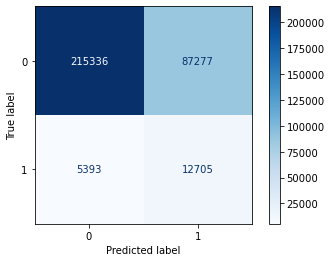

f1 : 0.2152
f3 : 0.4833
f5 : 0.5980
recall : 0.7020
negative predictive value : 0.9756
precision : 0.1271
roc_auc : 0.7818
training time : 10.626s
prediction time : 0.03s


In [24]:
m = Modelisation(X, y, LogisticRegression(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

SCORES = []
metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

## 3. Régression logistique avec oversampling

In [25]:
len(y[y == 1]) / (len(y[y == 0]))

0.06049828183239467

In [26]:
df_small = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.05)
df_small.shape

(80525, 48)

In [27]:
datasets_df_small = datasets(df_small, verbose=False, drop='first')
X_small = datasets_df_small['X_only_quant_scaled']
y_small = datasets_df_small['y']

In [28]:
categorical_features = list(range(len(COLUMNS_QUANT), len(X.columns)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features,
               sampling_strategy=1,
               k_neighbors=5,
               random_state=1234,
               n_jobs=-1)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


Export PDF : output/model_LR/13.pdf



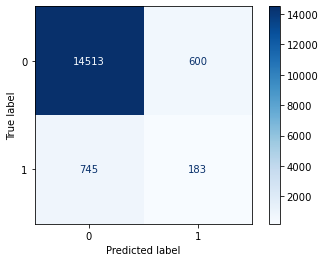

f1 : 0.2139
f3 : 0.2003
f5 : 0.1984
recall : 0.1972
negative predictive value : 0.9512
precision : 0.2337
roc_auc : 0.7014
training time : 48.622s
prediction time : 0.009s


In [29]:
m = Modelisation(X_small, y_small, pipeline)
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

In [30]:
over = RandomOverSampler(sampling_strategy=1, random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

Export PDF : output/model_LR/14.pdf



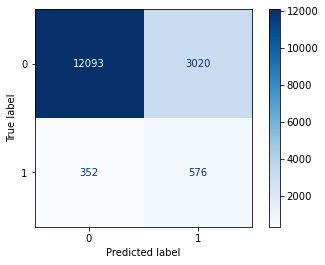

f1 : 0.2546
f3 : 0.4821
f5 : 0.5589
recall : 0.6207
negative predictive value : 0.9717
precision : 0.1602
roc_auc : 0.7721
training time : 0.984s
prediction time : 0.005s


In [31]:
m = Modelisation(X_small, y_small, pipeline)
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

### 3.1. GridSearchCV avec RandomOverSampler

In [32]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

cv_params = {
    "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    "model__C": np.logspace(-6, 2, 30),
    "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                            {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                            {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                            {0:1, 1:30}, {0:1, 1:32}]
}

print(len(ParameterGrid(cv_params)))

3240


In [33]:
# SearchCV(pipeline, cv_params, data_frac=1, drop='first', scaling=True, sparse=True, n_jobs=35)

In [34]:
dico, results = restauration_CV('RandomOver_LR_CV_Grid_3240_1')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', LogisticRegression())])
model_name : RandomOver_LR
type : GridSearchCV
len_grid : 3240
columns_quant : default
columns_cat : default
drop : first
data_frac : 1
n_jobs : 35
temps : 7h, 26min, 5.051s
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'model__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 6}, {0:

Export PDF : output/model_LR/15.pdf



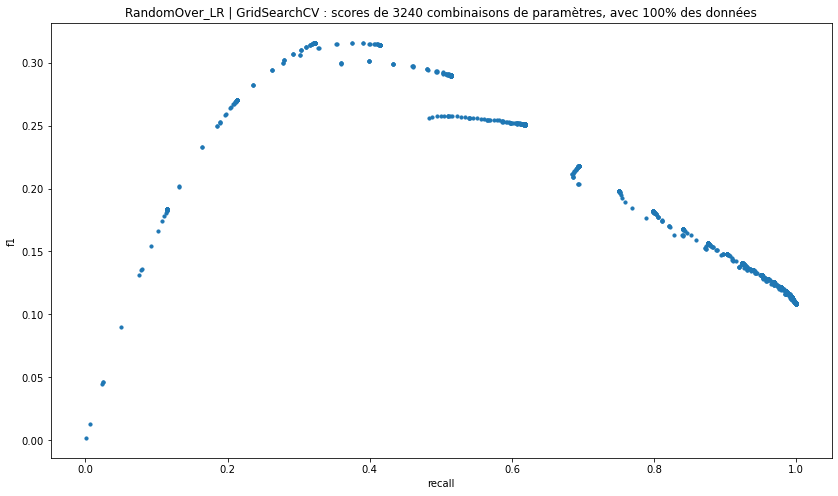

In [35]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=10, pdf=pdf)

Export PDF : output/model_LR/16.pdf



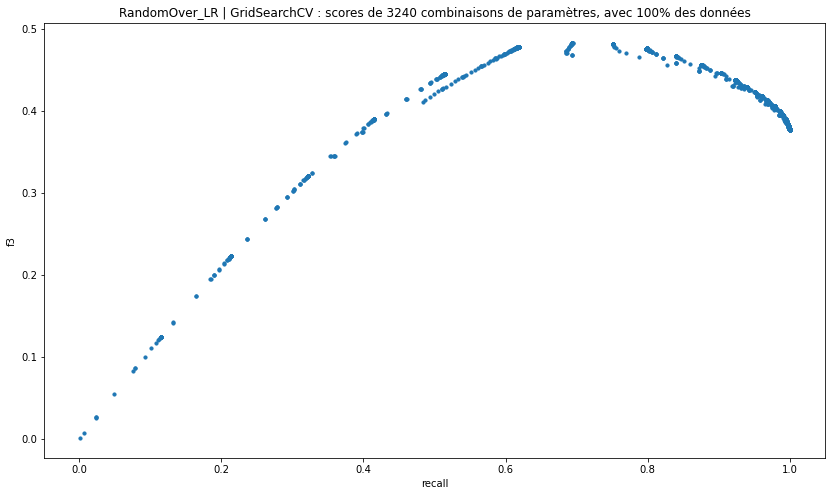

In [36]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=10, pdf=pdf)

Export PDF : output/model_LR/17.pdf



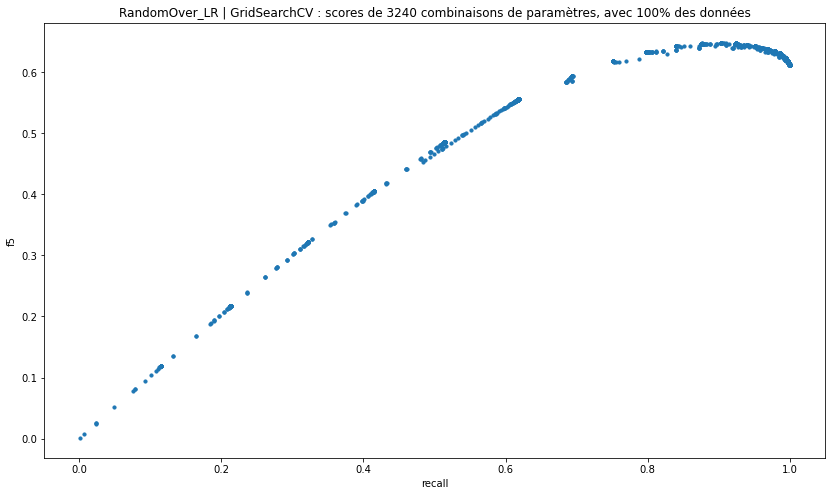

In [37]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=10, pdf=pdf)

Export PDF : output/model_LR/18.pdf



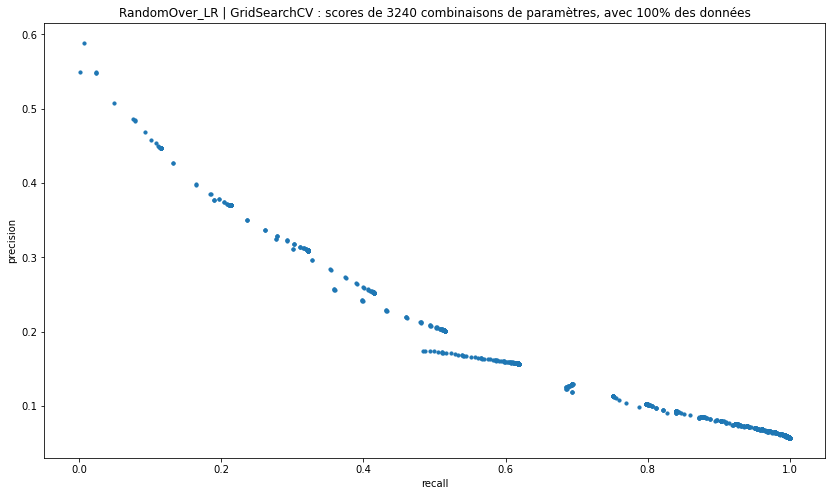

In [38]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=10, pdf=pdf)

Export PDF : output/model_LR/19.pdf



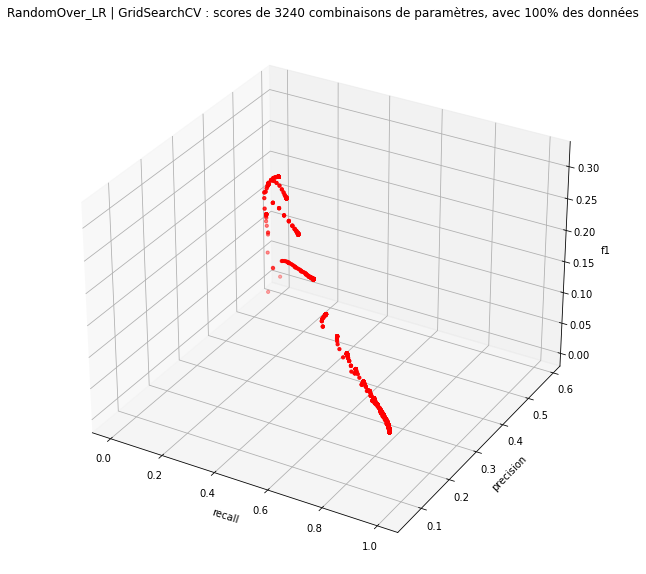

In [39]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=10, pdf=pdf)

Export PDF : output/model_LR/20.pdf



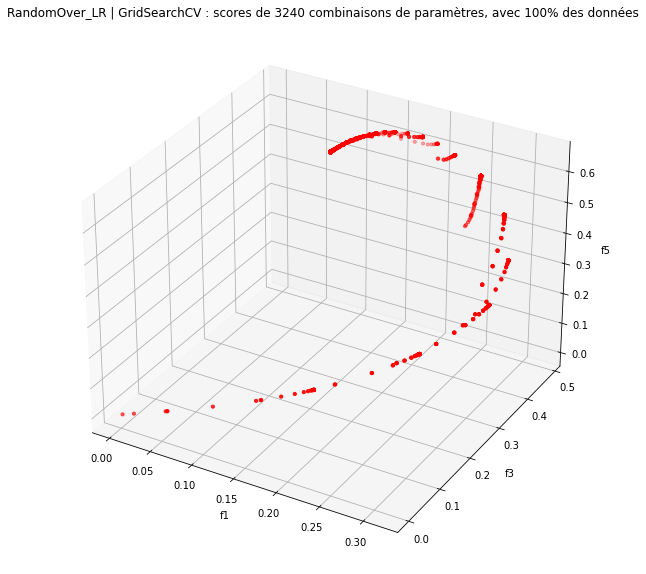

In [40]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=10, pdf=pdf)

Export PDF : output/model_LR/21.pdf



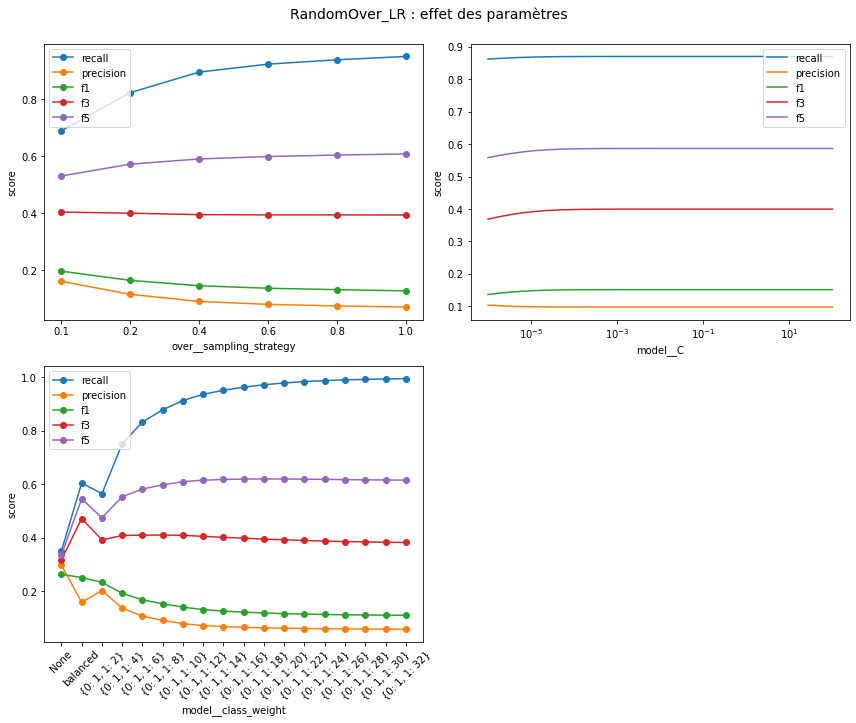

In [41]:
graph_param_CV(dico, results, xscale={'model__C': 'log'}, ncols=2, height=5, width=6, pdf=pdf)

In [42]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_over__sampling_strategy,params,mean_test_recall,std_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
2823,64.77451,7.007041,2.259698,0.402582,14.873521,"{0: 1, 1: 2}",0.6,"{'model__C': 14.873521072935118, 'model__class...",0.694047,0.002271,...,603,0.218248,0.000471,566,0.483314,0.001273,1,0.594371,0.001754,2553
1959,66.136087,3.278822,2.165124,0.383783,0.092367,"{0: 1, 1: 2}",0.6,"{'model__C': 0.09236708571873865, 'model__clas...",0.694047,0.002258,...,605,0.218247,0.000465,568,0.483312,0.001261,2,0.59437,0.001741,2554
2715,56.307329,13.31596,1.807191,0.713208,7.880463,"{0: 1, 1: 2}",0.6,"{'model__C': 7.880462815669905, 'model__class_...",0.694036,0.002275,...,601,0.218249,0.000468,565,0.48331,0.001271,3,0.594364,0.001755,2560
2283,65.637875,13.173515,1.944539,0.665197,0.621017,"{0: 1, 1: 2}",0.6,"{'model__C': 0.6210169418915616, 'model__class...",0.694047,0.002269,...,608,0.218245,0.000467,570,0.48331,0.001267,4,0.594369,0.001749,2555
1527,63.712114,11.592528,1.978558,0.428265,0.007279,"{0: 1, 1: 2}",0.6,"{'model__C': 0.007278953843983146, 'model__cla...",0.694036,0.002258,...,607,0.218244,0.000473,571,0.483306,0.00127,5,0.594361,0.001746,2561
2185,46.852164,8.795607,2.074949,0.565196,0.329034,"{0: 1, 1: 6}",0.2,"{'model__C': 0.3290344562312671, 'model__class...",0.694068,0.002339,...,617,0.21823,0.000366,581,0.483304,0.001171,6,0.594375,0.001725,2551
1851,68.146763,4.867502,2.376247,0.076677,0.048939,"{0: 1, 1: 2}",0.6,"{'model__C': 0.04893900918477489, 'model__clas...",0.694025,0.002279,...,604,0.218246,0.000473,569,0.483303,0.001274,7,0.594355,0.001758,2563
2617,48.35015,8.179217,2.077064,0.519671,4.175319,"{0: 1, 1: 6}",0.2,"{'model__C': 4.175318936560401, 'model__class_...",0.694068,0.002339,...,618,0.218229,0.000364,582,0.483303,0.001169,8,0.594375,0.001724,2552
2931,62.607317,13.718383,2.148783,0.556202,28.072162,"{0: 1, 1: 2}",0.6,"{'model__C': 28.072162039411758, 'model__class...",0.694025,0.002279,...,606,0.218244,0.000468,572,0.483301,0.001272,9,0.594354,0.001757,2564
2499,62.010667,7.555004,2.25931,0.422455,2.212216,"{0: 1, 1: 2}",0.6,"{'model__C': 2.21221629107045, 'model__class_w...",0.694014,0.002289,...,602,0.218247,0.000465,567,0.4833,0.001274,10,0.594348,0.001763,2569


Meilleure combinaison de paramètres pour f3 :


{'model__C': 14.873521072935118,
 'model__class_weight': {0: 1, 1: 2},
 'over__sampling_strategy': 0.6}

In [43]:
PARAMS[dico['model_name']] = best_params

Export PDF : output/model_LR/22.pdf



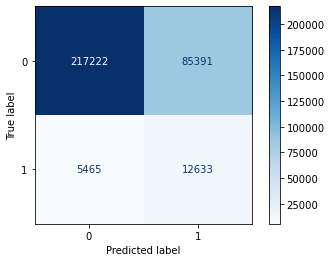

f1 : 0.2176
f3 : 0.4842
f5 : 0.5967
recall : 0.6980
negative predictive value : 0.9755
precision : 0.1289
roc_auc : 0.7819
training time : 18.55s
prediction time : 0.033s


In [44]:
m = Modelisation(X, y, pipeline.set_params(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 3.2. GridSearchCV avec SMOTENC

In [45]:
categorical_features = list(range(len(COLUMNS_QUANT), len(X.columns)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features,
               random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

cv_params = {
    "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    "model__C": np.logspace(-6, 2, 30),
    "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                            {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                            {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                            {0:1, 1:30}, {0:1, 1:32}] 
}

print(len(ParameterGrid(cv_params)))

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
3240


In [46]:
# SearchCV(pipeline, cv_params, data_frac=0.2, drop='first', scaling=True, sparse=True, n_jobs=35)

In [47]:
dico, results = restauration_CV('SMOTENC_LR_CV_Grid_3240_0.2')

model : Pipeline(steps=[('over',
                 SMOTENC(categorical_features=[13, 14, 15, 16, 17, 18, 19, 20,
                                               21, 22, 23, 24, 25, 26, 27, 28,
                                               29, 30, 31, 32, 33, 34, 35, 36,
                                               37, 38, 39, 40, 41, 42, ...],
                         random_state=1234)),
                ('model', LogisticRegression())])
model_name : SMOTENC_LR
type : GridSearchCV
len_grid : 3240
columns_quant : default
columns_cat : default
drop : first
data_frac : 0.2
n_jobs : 35
temps : 1day, 20h, 27min, 50.387s
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.5929

Export PDF : output/model_LR/23.pdf



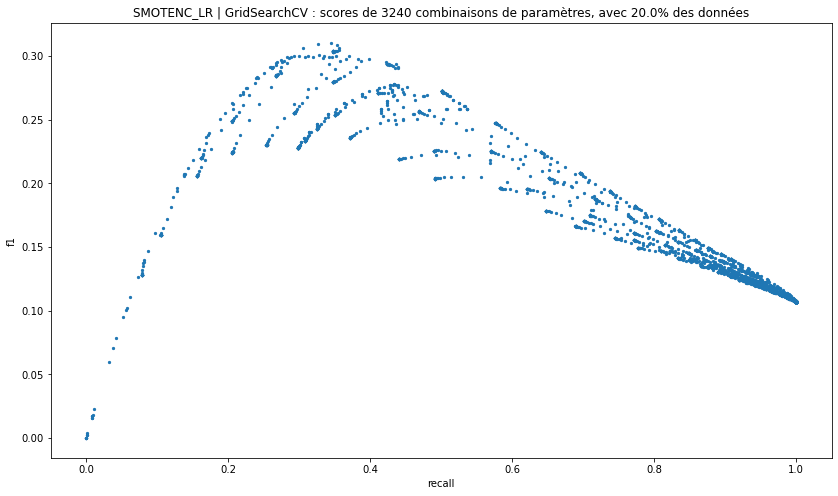

In [48]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=5, pdf=pdf)

Export PDF : output/model_LR/24.pdf



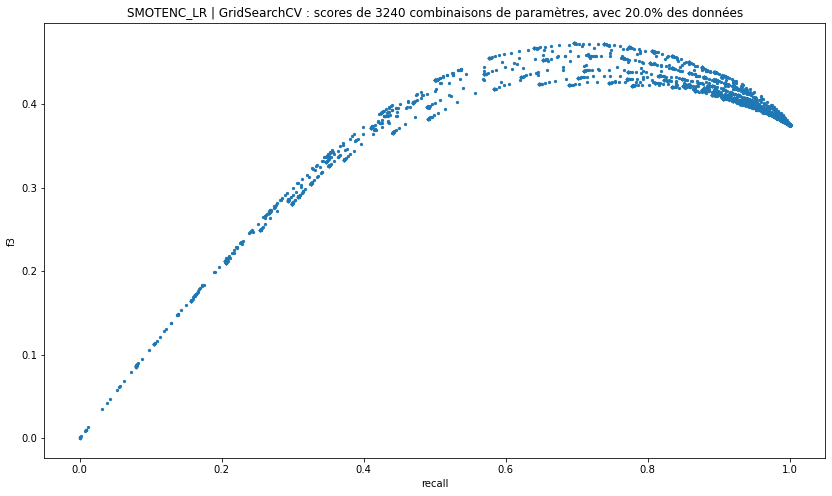

In [49]:
graph_2scores_CV(dico, results, 'recall', 'f3', s=5, pdf=pdf)

Export PDF : output/model_LR/25.pdf



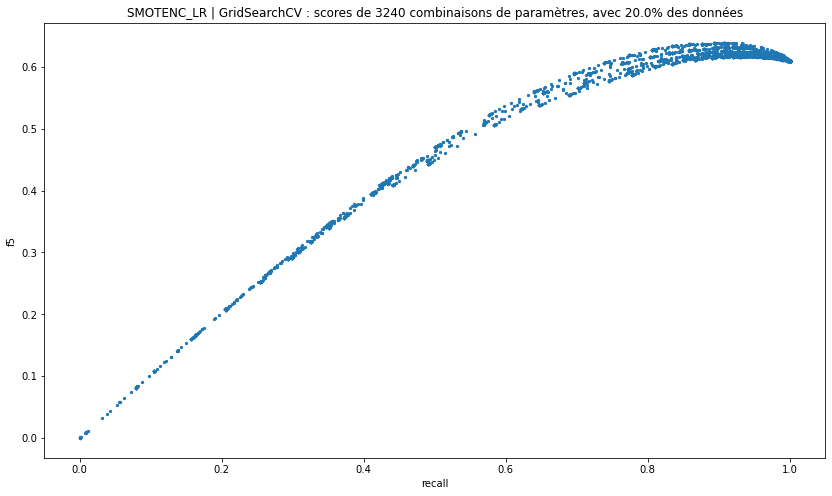

In [50]:
graph_2scores_CV(dico, results, 'recall', 'f5', s=5, pdf=pdf)

Export PDF : output/model_LR/26.pdf



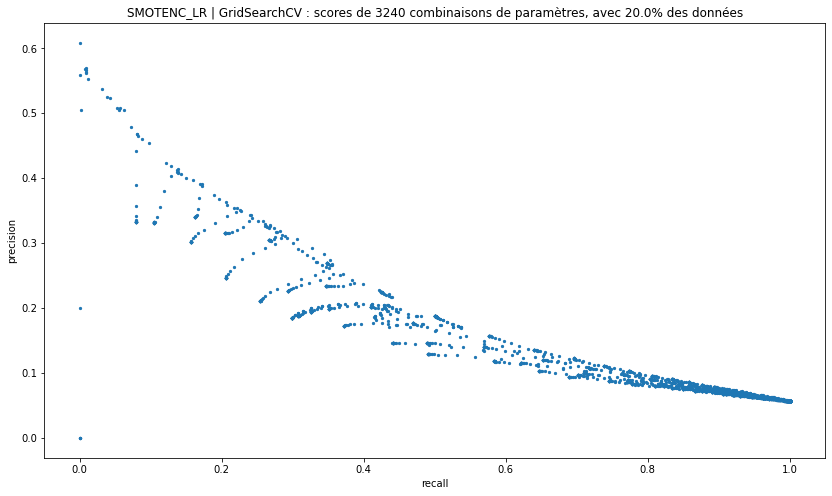

In [51]:
graph_2scores_CV(dico, results, 'recall', 'precision', s=5, pdf=pdf)

Export PDF : output/model_LR/27.pdf



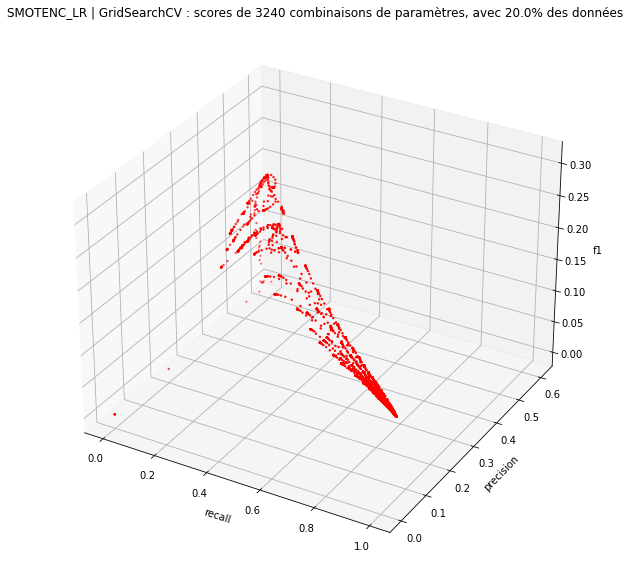

In [52]:
graph_3scores_CV(dico, results, 'recall', 'precision', 'f1', s=2, pdf=pdf)

Export PDF : output/model_LR/28.pdf



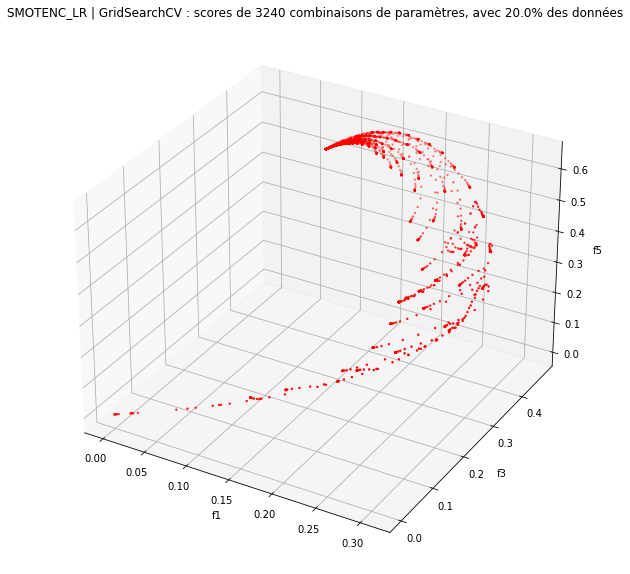

In [53]:
graph_3scores_CV(dico, results, 'f1', 'f3', 'f5', s=2, pdf=pdf)

Export PDF : output/model_LR/29.pdf



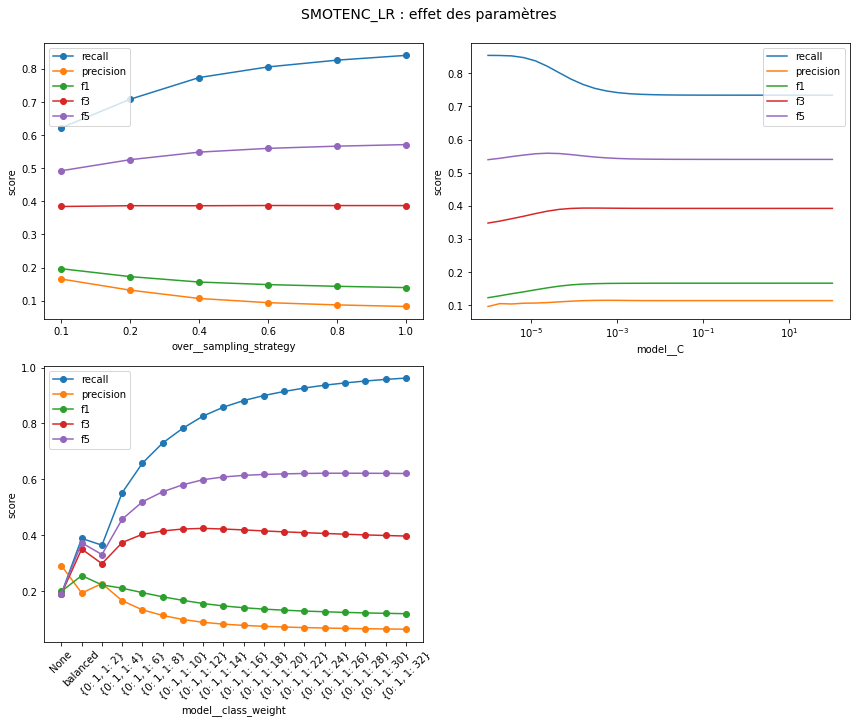

In [54]:
graph_param_CV(dico, results, xscale={'model__C': 'log'}, ncols=2, height=5, width=6, pdf=pdf)

In [55]:
best_params = best_score_CV(dico, results, 'f3')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__class_weight,param_over__sampling_strategy,params,mean_test_recall,std_test_recall,...,rank_test_precision,mean_test_f1,std_test_f1,rank_test_f1,mean_test_f3,std_test_f3,rank_test_f3,mean_test_f5,std_test_f5,rank_test_f5
2754,280.367712,3.648103,0.176428,0.005199,7.880463,"{0: 1, 1: 16}",0.1,"{'model__C': 7.880462815669905, 'model__class_...",0.695537,0.011211,...,796,0.208202,0.001953,685,0.473696,0.003599,1,0.589361,0.006898,2211
2862,279.467389,5.464788,0.174586,0.008515,14.873521,"{0: 1, 1: 16}",0.1,"{'model__C': 14.873521072935118, 'model__class...",0.695537,0.011211,...,797,0.208201,0.001953,686,0.473695,0.003602,2,0.58936,0.006899,2212
2538,440.681257,9.001911,0.285405,0.067474,2.212216,"{0: 1, 1: 16}",0.1,"{'model__C': 2.21221629107045, 'model__class_w...",0.695537,0.011211,...,798,0.208199,0.001953,687,0.473693,0.003602,3,0.589359,0.006899,2215
2970,281.79645,5.264976,0.176508,0.006723,28.072162,"{0: 1, 1: 16}",0.1,"{'model__C': 28.072162039411758, 'model__class...",0.695537,0.011211,...,799,0.208199,0.001952,688,0.473693,0.003604,4,0.589359,0.006901,2213
2646,413.002226,6.437737,0.288153,0.066923,4.175319,"{0: 1, 1: 16}",0.1,"{'model__C': 4.175318936560401, 'model__class_...",0.695537,0.011211,...,800,0.208199,0.001951,689,0.473693,0.003603,5,0.589359,0.0069,2214
3078,282.981381,6.925481,0.176365,0.007416,52.983169,"{0: 1, 1: 16}",0.1,"{'model__C': 52.98316906283702, 'model__class_...",0.695537,0.011211,...,801,0.208197,0.001955,690,0.473691,0.003603,6,0.589358,0.0069,2216
3186,270.249304,18.159382,0.177592,0.018211,100.0,"{0: 1, 1: 16}",0.1,"{'model__C': 100.0, 'model__class_weight': {0:...",0.695537,0.011211,...,801,0.208197,0.001955,690,0.473691,0.003603,6,0.589358,0.0069,2216
1674,246.488446,32.116285,0.163267,0.022894,0.013738,"{0: 1, 1: 16}",0.1,"{'model__C': 0.013738237958832637, 'model__cla...",0.696474,0.011323,...,810,0.20786,0.001981,699,0.473689,0.003698,8,0.589771,0.006994,2207
2430,277.893903,4.367013,0.18284,0.008147,1.172102,"{0: 1, 1: 16}",0.1,"{'model__C': 1.1721022975334794, 'model__class...",0.695537,0.011211,...,803,0.208193,0.001948,692,0.473687,0.003609,9,0.589356,0.006905,2218
2322,282.232374,2.87278,0.199311,0.043966,0.621017,"{0: 1, 1: 16}",0.1,"{'model__C': 0.6210169418915616, 'model__class...",0.695537,0.011211,...,804,0.208183,0.001955,693,0.473677,0.003598,10,0.58935,0.006896,2219


Meilleure combinaison de paramètres pour f3 :


{'model__C': 7.880462815669905,
 'model__class_weight': {0: 1, 1: 16},
 'over__sampling_strategy': 0.1}

In [56]:
best_params['over__n_jobs'] = -1
PARAMS[dico['model_name']] = best_params

Export PDF : output/model_LR/30.pdf



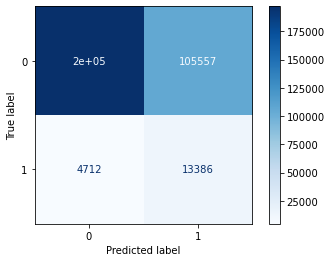

f1 : 0.1954
f3 : 0.4750
f5 : 0.6091
recall : 0.7396
negative predictive value : 0.9766
precision : 0.1125
roc_auc : 0.7731
training time : 22min, 30.116s
prediction time : 0.039s


In [57]:
m = Modelisation(X, y, pipeline.set_params(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 3.3. Comparaison

In [58]:
dr1 = restauration_CV('LR_CV_Grid_540_1', verbose=False)
dr2 = restauration_CV('RandomOver_LR_CV_Grid_3240_1', verbose=False)
dr3 = restauration_CV('SMOTENC_LR_CV_Grid_3240_0.2', verbose=False)

Export PDF : output/model_LR/31.pdf



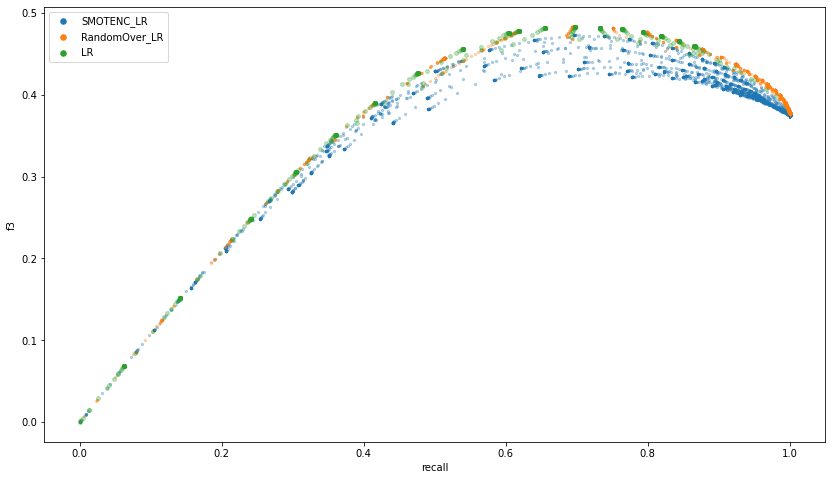

In [59]:
graph_2scores_CV_comp([dr3, dr2, dr1], 'recall', 'f3', s=[5, 5, 15], alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/32.pdf



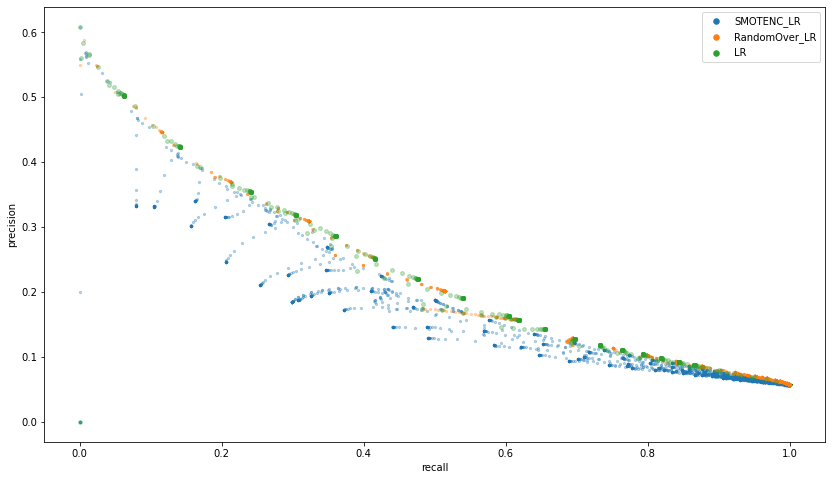

In [60]:
graph_2scores_CV_comp([dr3, dr2, dr1], 'recall', 'precision', s=[5, 5, 15], alpha=0.3, pdf=pdf)

## 4. Régression logistique avec RFECV

### 4.1. Sans oversampling

In [61]:
with open("backups/RFECV_LR.json", 'r') as f:
    export = json.load(f)
    columns_quant_RFECV = export['columns_quant']
    columns_cat_RFECV = export['columns_cat']

In [62]:
model = LogisticRegression()

cv_params = {
    "C": np.logspace(-6, 2, 30),
    "class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                     {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                     {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                     {0:1, 1:30}, {0:1, 1:32}] 
}

print(len(ParameterGrid(cv_params)))

540


In [63]:
# SearchCV(model, cv_params, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV, data_frac=1, drop='first', scaling=True, sparse=True, n_jobs=35, name='RFECV')

In [64]:
dico, results = restauration_CV('LR_RFECV_CV_Grid_540_1')

model : LogisticRegression()
model_name : LR_RFECV
type : GridSearchCV
len_grid : 540
columns_quant : ['campaignctrlast24h', 'display_size', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
columns_cat : ['campaignscenario_13', 'device_type_Desktop', 'device_type_iPhone', 'display_env_app_ios', 'is_interstitial_True', 'target_env_2']
drop : first
data_frac : 1
n_jobs : 35
temps : 15min, 9.364s
params : {'C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02]), 'class_weight': [None, 'balanced', {0:

In [65]:
best_params = best_score_CV(dico, results, 'f3', display_table=False)

Meilleure combinaison de paramètres pour f3 :


{'C': 0.007278953843983146, 'class_weight': {0: 1, 1: 20}}

In [66]:
PARAMS[dico['model_name']] = best_params

In [67]:
datasets_df_RFECV = datasets(df, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV, drop='first')
X_RFECV = datasets_df_RFECV['X_only_quant_scaled']

Columns_quant : ['campaignctrlast24h', 'display_size', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
Columns_cat : ['campaignscenario_13', 'device_type_Desktop', 'device_type_iPhone', 'display_env_app_ios', 'is_interstitial_True', 'target_env_2']
drop : first

Nombre de variables pour X_quant : 5



Index(['campaignctrlast24h', 'display_size', 'nbdayssincelastclick',
       'nbdisplay_1hour', 'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 6



Index(['campaignscenario_13', 'device_type_Desktop', 'device_type_iPhone',
       'display_env_app_ios', 'is_interstitial_True', 'target_env_2'],
      dtype='object')


Nombre de variables pour X : 11


Export PDF : output/model_LR/33.pdf



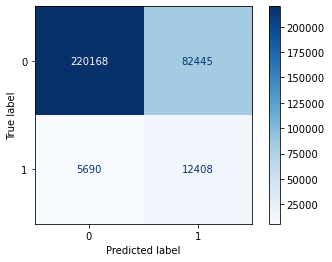

f1 : 0.2197
f3 : 0.4814
f5 : 0.5895
recall : 0.6856
negative predictive value : 0.9748
precision : 0.1308
roc_auc : 0.7781
training time : 2.302s
prediction time : 0.013s


In [68]:
m = Modelisation(X_RFECV, y, LogisticRegression(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 4.2. Avec oversampling (RandomOverSampler)

In [69]:
over = RandomOverSampler(random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

cv_params = {
        "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        "model__C": np.logspace(-6, 2, 30),
        "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                                 {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                                 {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                                 {0:1, 1:30}, {0:1, 1:32}]
        }

print(len(ParameterGrid(cv_params)))

3240


In [70]:
# SearchCV(pipeline, cv_params, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV, data_frac=1, drop='first', scaling=True, sparse=True, n_jobs=35, name='RFECV')

In [71]:
dico, results = restauration_CV('RandomOver_LR_RFECV_CV_Grid_3240_1')

model : Pipeline(steps=[('over', RandomOverSampler(random_state=1234)),
                ('model', LogisticRegression())])
model_name : RandomOver_LR_RFECV
type : GridSearchCV
len_grid : 3240
columns_quant : ['campaignctrlast24h', 'display_size', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
columns_cat : ['campaignscenario_13', 'device_type_Desktop', 'device_type_iPhone', 'display_env_app_ios', 'is_interstitial_True', 'target_env_2']
drop : first
data_frac : 1
n_jobs : 35
temps : 2h, 30min, 57.146s
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.172102

In [72]:
best_params = best_score_CV(dico, results, 'f3', display_table=False)

Meilleure combinaison de paramètres pour f3 :


{'model__C': 0.013738237958832637,
 'model__class_weight': {0: 1, 1: 2},
 'over__sampling_strategy': 0.6}

In [73]:
PARAMS[dico['model_name']] = best_params

Export PDF : output/model_LR/34.pdf



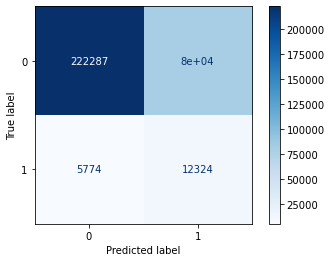

f1 : 0.2226
f3 : 0.4823
f5 : 0.5878
recall : 0.6810
negative predictive value : 0.9747
precision : 0.1330
roc_auc : 0.7782
training time : 3.703s
prediction time : 0.014s


In [74]:
m = Modelisation(X_RFECV, y, pipeline.set_params(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 4.3. Avec oversampling (SMOTENC)

In [75]:
categorical_features = list(range(len(columns_quant_RFECV), len(columns_quant_RFECV) + len(columns_cat_RFECV)))
print(categorical_features)

over = SMOTENC(categorical_features=categorical_features,
               random_state=1234)

pipeline = Pipeline_imb([('over', over),
                         ('model', LogisticRegression())
                         ])

cv_params = {
    "over__sampling_strategy": [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    "model__C": np.logspace(-6, 2, 30),
    "model__class_weight": [None, 'balanced', {0:1, 1:2}, {0:1, 1:4}, {0:1, 1:6}, {0:1, 1:8}, 
                            {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:14}, {0:1, 1:16}, {0:1, 1:18}, 
                            {0:1, 1:20}, {0:1, 1:22}, {0:1, 1:24}, {0:1, 1:26}, {0:1, 1:28}, 
                            {0:1, 1:30}, {0:1, 1:32}] 
}

print(len(ParameterGrid(cv_params)))

[5, 6, 7, 8, 9, 10]
3240


In [76]:
# SearchCV(pipeline, cv_params, columns_quant=columns_quant_RFECV, columns_cat=columns_cat_RFECV, data_frac=0.2, drop='first', scaling=True, sparse=True, n_jobs=35, name='RFECV')

In [77]:
dico, results = restauration_CV('SMOTENC_LR_RFECV_CV_Grid_3240_0.2')

model : Pipeline(steps=[('over',
                 SMOTENC(categorical_features=[5, 6, 7, 8, 9, 10],
                         random_state=1234)),
                ('model', LogisticRegression())])
model_name : SMOTENC_LR_RFECV
type : GridSearchCV
len_grid : 3240
columns_quant : ['campaignctrlast24h', 'display_size', 'nbdayssincelastclick', 'nbdisplay_1hour', 'zonecostineuro']
columns_cat : ['campaignscenario_13', 'device_type_Desktop', 'device_type_iPhone', 'display_env_app_ios', 'is_interstitial_True', 'target_env_2']
drop : first
data_frac : 0.2
n_jobs : 35
temps : 5h, 28min, 40.188s
params : {'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.8, 1], 'model__C': array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.2367

In [78]:
best_params = best_score_CV(dico, results, 'f3', display_table=False)

Meilleure combinaison de paramètres pour f3 :


{'model__C': 0.0020433597178569417,
 'model__class_weight': {0: 1, 1: 12},
 'over__sampling_strategy': 0.1}

In [79]:
best_params['over__n_jobs'] = -1
PARAMS[dico['model_name']] = best_params
with open("backups/PARAMS_LR.json", 'w') as f:
    json.dump(PARAMS, f, indent=2)

Export PDF : output/model_LR/35.pdf



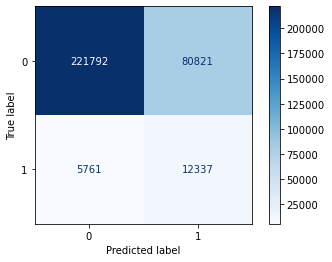

f1 : 0.2218
f3 : 0.4818
f5 : 0.5879
recall : 0.6817
negative predictive value : 0.9747
precision : 0.1324
roc_auc : 0.7778
training time : 5min, 5.536s
prediction time : 0.012s


In [80]:
m = Modelisation(X_RFECV, y, pipeline.set_params(**best_params))
m.show_conf_matrix(pdf=pdf)
m.show_metrics_score()

metrics = m.metrics_score
metrics['model_name'] = dico['model_name']
metrics['training_time'] = m.training_time
metrics['prediction_time'] = m.prediction_time
SCORES.append(metrics)

### 4.3. Comparaison

In [81]:
dr1 = restauration_CV('LR_CV_Grid_540_1', verbose=False)
dr2 = restauration_CV('LR_RFECV_CV_Grid_540_1', verbose=False)
dr3 = restauration_CV('RandomOver_LR_CV_Grid_3240_1', verbose=False)
dr4 = restauration_CV('RandomOver_LR_RFECV_CV_Grid_3240_1', verbose=False)
dr5 = restauration_CV('SMOTENC_LR_CV_Grid_3240_0.2', verbose=False)
dr6 = restauration_CV('SMOTENC_LR_RFECV_CV_Grid_3240_0.2', verbose=False)

Export PDF : output/model_LR/36.pdf



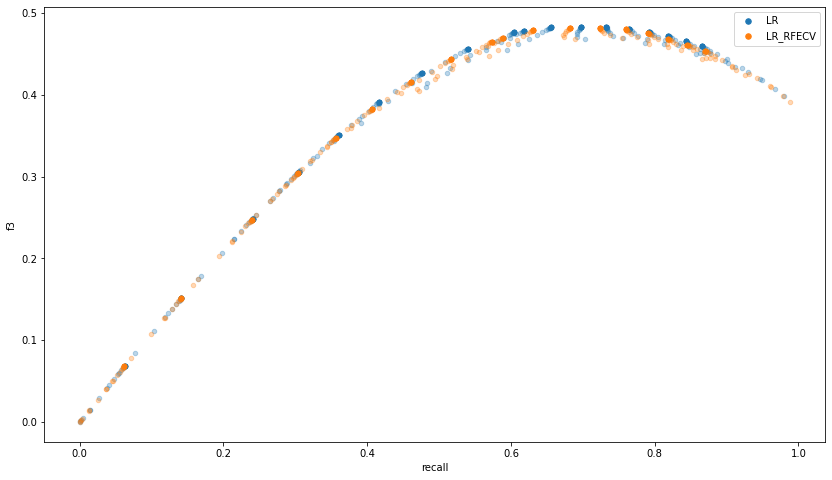

In [82]:
graph_2scores_CV_comp([dr1, dr2], 'recall', 'f3', alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/37.pdf



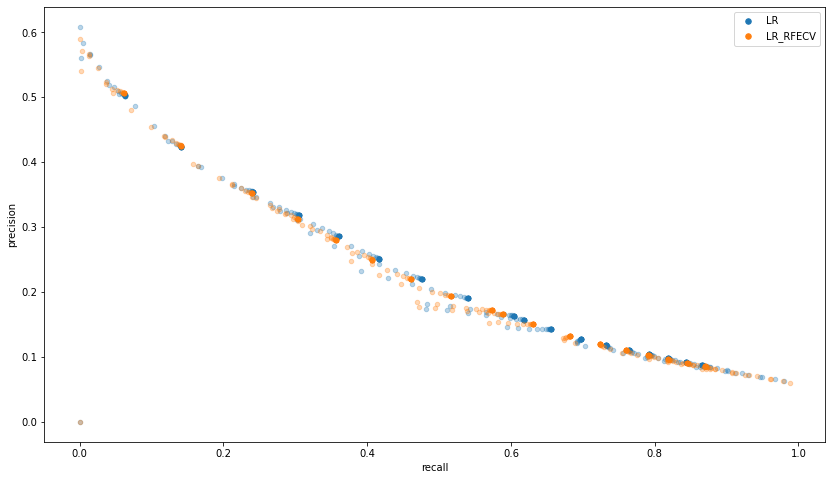

In [83]:
graph_2scores_CV_comp([dr1, dr2], 'recall', 'precision', alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/38.pdf



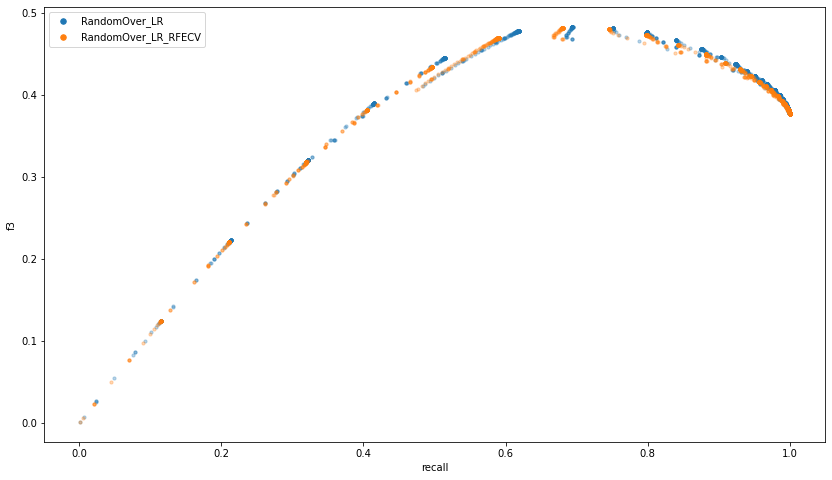

In [84]:
graph_2scores_CV_comp([dr3, dr4], 'recall', 'f3', s=[10, 10], alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/39.pdf



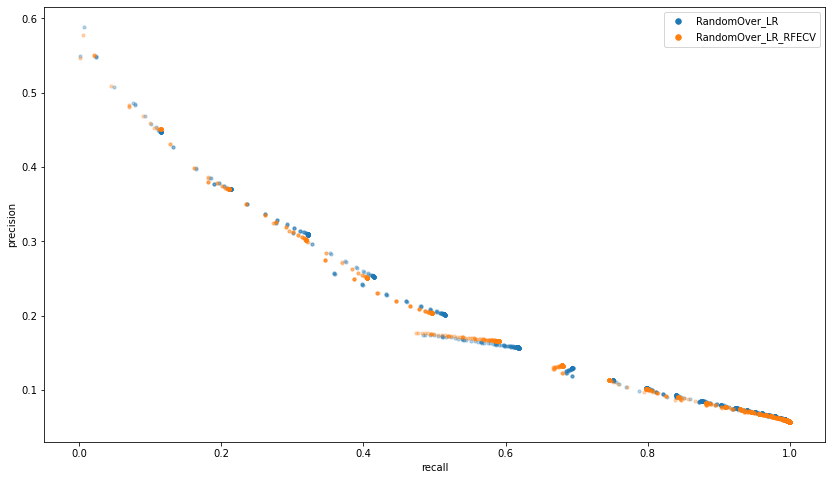

In [85]:
graph_2scores_CV_comp([dr3, dr4], 'recall', 'precision', s=[10, 10], alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/40.pdf



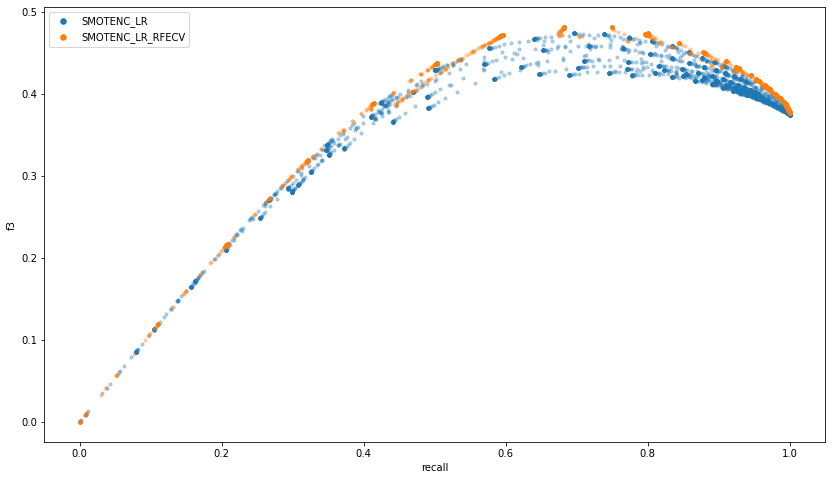

In [86]:
graph_2scores_CV_comp([dr5, dr6], 'recall', 'f3', s=[10, 10], alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/41.pdf



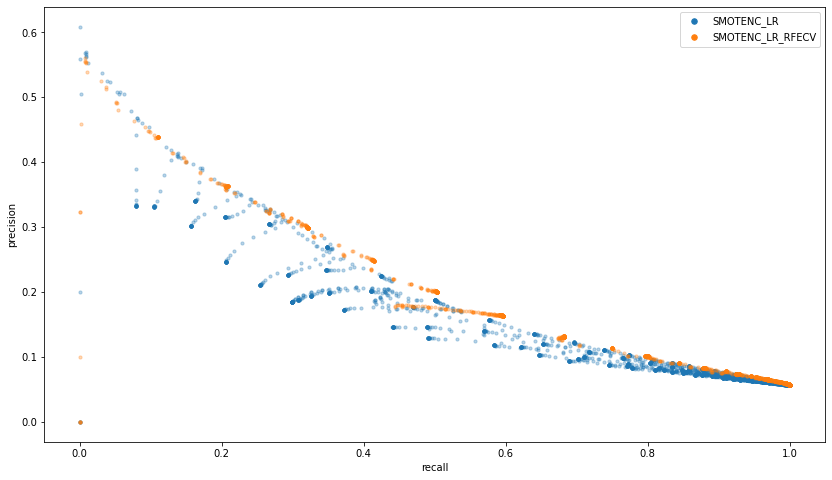

In [87]:
graph_2scores_CV_comp([dr5, dr6], 'recall', 'precision', s=[10, 10], alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/42.pdf



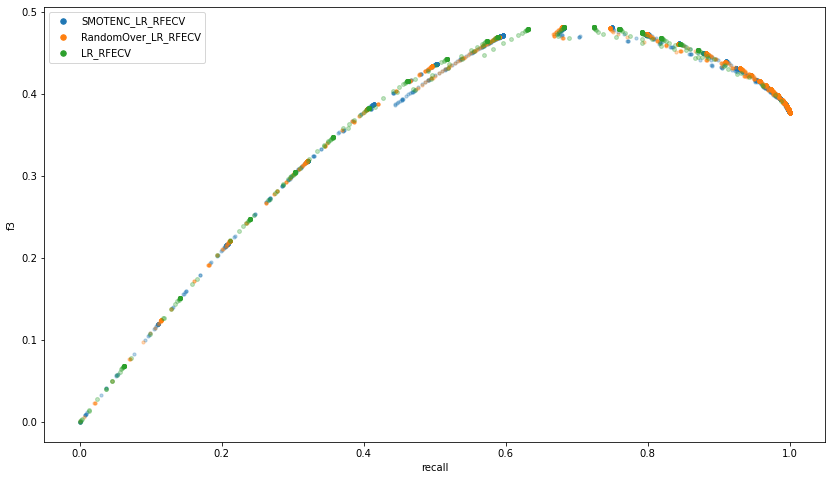

In [88]:
graph_2scores_CV_comp([dr6, dr4, dr2], 'recall', 'f3', s=[10, 10, 15], alpha=0.3, pdf=pdf)

Export PDF : output/model_LR/43.pdf



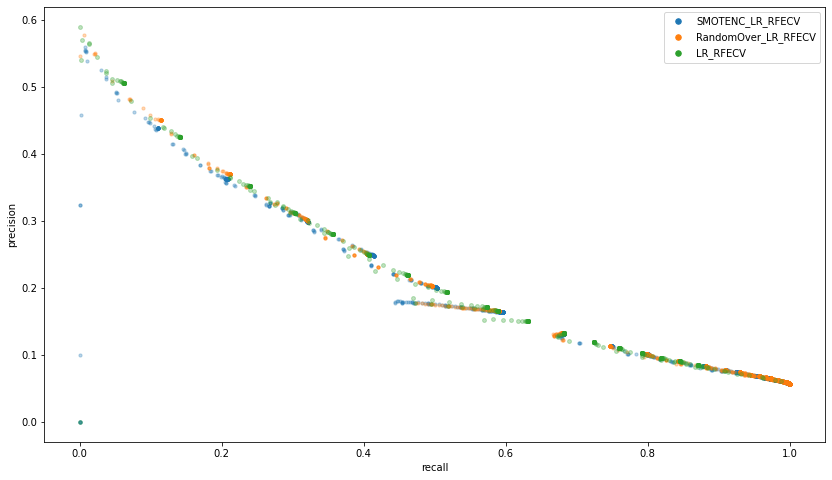

In [89]:
graph_2scores_CV_comp([dr6, dr4, dr2], 'recall', 'precision', s=[10, 10, 15], alpha=0.3, pdf=pdf)

## 5. Bilan

In [90]:
scores_df = pd.DataFrame(SCORES).set_index('model_name')
a = scores_df.columns.tolist()
a.remove('training_time')
a.remove('prediction_time')
scores_df.sort_values(by='f3', ascending=False).to_csv('backups/SCORES_LR.csv')
scores_df.sort_values(by='f3', ascending=False).style.background_gradient(cmap='Blues', subset=a).background_gradient(cmap='Blues_r', subset=['training_time', 'prediction_time'])

,f1,f3,f5,recall,negative predictive value,precision,roc_auc,training_time,prediction_time
model_name,,,,,,,,,
RandomOver_LR,0.217582,0.484197,0.596682,0.698033,0.975459,0.128877,0.781939,18.549829,0.032685
LR,0.215193,0.483330,0.597956,0.702011,0.975567,0.127073,0.781808,10.626166,0.029853
RandomOver_LR_RFECV,0.222559,0.482288,0.587826,0.680959,0.974682,0.133017,0.778232,3.703437,0.014398
SMOTENC_LR_RFECV,0.221777,0.481839,0.587898,0.681678,0.974683,0.132431,0.777836,305.536379,0.012130
LR_RFECV,0.219706,0.481425,0.589450,0.685601,0.974807,0.130813,0.778104,2.301516,0.012589
SMOTENC_LR,0.195358,0.474976,0.609101,0.739640,0.976646,0.112541,0.773115,1350.115784,0.039019


In [91]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:31:28
